In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from numpy.random import seed
seed(1337)

import tensorflow as tf
tf.random.set_seed(42)

# from tensorflow.python.keras.applications import vgg16
from tensorflow.keras.applications import ResNet152V2
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [2]:
# If this is not set, bug because tf takes too much memory
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_data_dir = "dataset/Train"
val_data_dir = "dataset/Validation"
test_data_dir = "dataset/Test"
category_names = sorted(os.listdir('dataset/Train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'dataset/Train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))

In [4]:
img_height, img_width = 224,224
#conv_base = vgg16.VGG16(weights='imagenet', include_top=False,
#                        pooling='max',
#                        input_shape = (img_width, img_height, 3))

conv_base = ResNet152V2(include_top = False,
                        pooling = 'avg',
                        input_shape = (img_width, img_height, 3),
                        weights = 'imagenet')

In [5]:
# Disabling all conv_base layers for training
conv_base.trainable = False

In [6]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 2048)              58331648  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 62,773,880
Trainable params: 4,442,232
Non-trainable params: 58,331,648
_________________________________________________________________


In [7]:
#Number of images to load at each iteration
batch_size = 32

# Rescaling and horizontal flip
train_datagen =  ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)

# these are generators for train/test data that will read pictures 
# found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 12348 images belonging to 120 classes.
Total number of images for "validation":
Found 4116 images belonging to 120 classes.
Total number of images for "testing":
Found 4116 images belonging to 120 classes.


In [8]:
learning_rate = 5e-5
epochs = 20
steps_per_epoch = int(12000 / (batch_size))
validation_steps = int(1200 / (batch_size))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3,
                                                mode='max',
                                                restore_best_weights=True)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate,
                                        clipnorm = 1.),
              metrics=['acc'])

In [9]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    shuffle=True, 
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[callback]
                    )

Epoch 1/20
375/375 [==============================] - 82s 218ms/step - loss: 2.6097 - acc: 0.4149 - val_loss: 1.0314 - val_acc: 0.7314
Epoch 2/20
375/375 [==============================] - 82s 219ms/step - loss: 1.0788 - acc: 0.7016 - val_loss: 0.8732 - val_acc: 0.7475
Epoch 3/20
375/375 [==============================] - 82s 218ms/step - loss: 0.8497 - acc: 0.7494 - val_loss: 0.7550 - val_acc: 0.7779
Epoch 4/20
375/375 [==============================] - 83s 222ms/step - loss: 0.7323 - acc: 0.7809 - val_loss: 0.7173 - val_acc: 0.7850
Epoch 5/20
375/375 [==============================] - 83s 221ms/step - loss: 0.6277 - acc: 0.8077 - val_loss: 0.8098 - val_acc: 0.7492
Epoch 6/20
375/375 [==============================] - 84s 223ms/step - loss: 0.5674 - acc: 0.8249 - val_loss: 0.6225 - val_acc: 0.8108
Epoch 7/20
375/375 [==============================] - 84s 224ms/step - loss: 0.5083 - acc: 0.8413 - val_loss: 0.7477 - val_acc: 0.7705
Epoch 8/20
375/375 [==============================] - 8

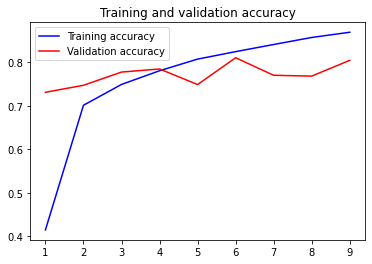

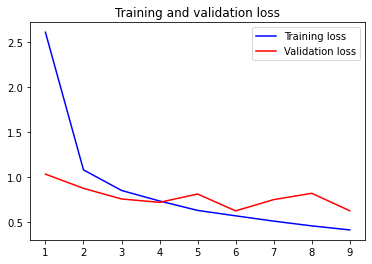

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')

In [11]:
import keras
from numba import cuda
# Clearing session as we will train model many time
keras.backend.clear_session()
# Releasing gpu memory directly with cuda
cuda.select_device(0)
cuda.close()